In [1]:
import matplotlib.pyplot as plt
plt.rcParams.update({"font.size": 9})
# PyTorch
import torch
import torchmetrics

/cluster/tufts/hugheslabkp/eharve06/miniconda3/envs/l3d_2024f_cuda12_1/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import sys
sys.path.append("../src/")

%load_ext autoreload
%autoreload 2
# Importing our custom module(s)
import layers
import models
import utils

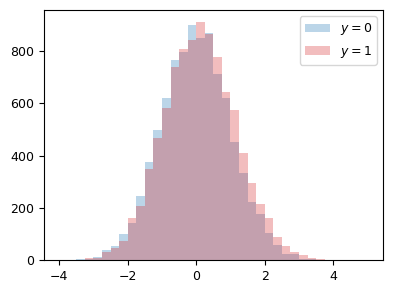

In [3]:
X_train, lengths_train, u_train, y_train = utils.generate_toy_data(800, delta=1.0, deltaS=3, seed=0)
X_val, lengths_val, u_val, y_val = utils.generate_toy_data(100, delta=1.0, deltaS=3, seed=1)
X_test, lengths_test, u_test, y_test = utils.generate_toy_data(100, delta=1.0, deltaS=3, seed=2)

X_y0 = torch.cat([X_i for i, X_i in enumerate(torch.split(X_train, lengths_train)) if y_train[i] == 0])
X_y1 = torch.cat([X_i for i, X_i in enumerate(torch.split(X_train, lengths_train)) if y_train[i] == 1])

def get_bins(data, width=0.25):
    min_val, max_val = torch.floor(data.min()), torch.ceil(data.max())
    return torch.arange(min_val, max_val + width, width)

ncols, nrows = 1, 1
fig, ax = plt.subplots(figsize=(4*ncols, 3*nrows), ncols=ncols, nrows=nrows)
ax.hist(X_y0[:,0], alpha=0.3, bins=get_bins(X_y0[:,0]), color="#1F77B4", label=r"$y=0$")
ax.hist(X_y1[:,0], alpha=0.3, bins=get_bins(X_y1[:,0]), color="#D62728", label=r"$y=1$")
ax.legend()
fig.tight_layout()
plt.show()

In [4]:
deltas = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]
bayes_aurocs = []

for delta in deltas:

    X_train, lengths_train, u_train, y_train = utils.generate_toy_data(500, delta=delta, deltaS=3, seed=0)
    X_val, lengths_val, u_val, y_val = utils.generate_toy_data(100, delta=delta, deltaS=3, seed=1)
    X_test, lengths_test, u_test, y_test = utils.generate_toy_data(100, delta=delta, deltaS=3, seed=2)

    auroc = torchmetrics.AUROC(task="binary")

    bayes_proba = torch.stack([utils.proba_y1_given_h(X_i[:,0], delta, deltaS=3) for X_i in torch.split(X_test, lengths_test)])
    bayes_aurocs.append(auroc(bayes_proba, y_test).item())

print(bayes_aurocs)

[0.520404040813446, 0.670707106590271, 0.8553534746170044, 0.9571717977523804, 0.9935353994369507, 0.9991918802261353, 0.9999999403953552, 1.0, 1.0, 1.0]


In [5]:
def max_logits(X, lengths, delta):
    
    model = models.ClfPool(in_features=768, out_features=1, pooling="max", use_pos_embedding=True)

    state_dict = {
        "clf.weight": torch.zeros(1, 769),
        "clf.bias": torch.zeros(1),
    }

    state_dict["clf.weight"][0,1] = 1.0
    state_dict["clf.bias"][0] = -delta/2

    model.load_state_dict(state_dict)
    
    logits, attention_weights = model(X, lengths)
    
    return logits

def mean_logits(X, lengths, delta):
    
    model = models.ClfPool(in_features=768, out_features=1, pooling="mean", use_pos_embedding=True)

    state_dict = {
        "clf.weight": torch.zeros(1, 769),
        "clf.bias": torch.zeros(1),
    }

    state_dict["clf.weight"][0,1] = 1.0
    state_dict["clf.bias"][0] = -delta/2

    model.load_state_dict(state_dict)
    
    logits, attention_weights = model(X, lengths)
    
    return logits

def attention_logits(X, lengths, delta):
    
    model = models.ClfPool(in_features=768, out_features=1, pooling="attention", use_pos_embedding=True)
    
    state_dict = {
        "clf.weight": torch.zeros(1, 769),
        "clf.bias": torch.zeros(1),
        "pool.mlp.0.weight": torch.zeros(128, 1),
        "pool.mlp.0.bias": torch.zeros(128),
        "pool.mlp.2.weight": torch.zeros(1, 128),
        "pool.mlp.2.bias": torch.zeros(1),
    }

    state_dict["clf.weight"][0,1] = 1.0
    state_dict["clf.bias"][0] = -delta/2
    state_dict["pool.mlp.0.weight"][0,0] = 0.01
    state_dict["pool.mlp.2.weight"][0,0] = 100.0

    model.load_state_dict(state_dict)

    logits, attention_weights = model(X, lengths)
    
    return logits

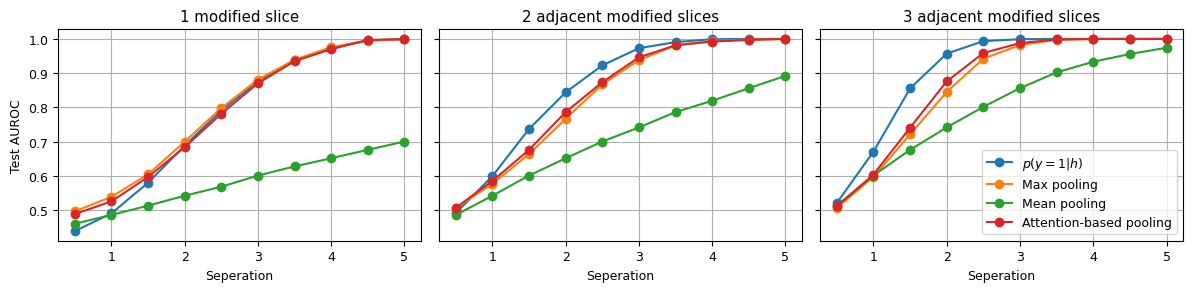

In [6]:
with torch.no_grad():
    
    ncols, nrows = 3, 1

    fig, axs = plt.subplots(figsize=(4*ncols, 3*nrows), ncols=ncols, nrows=nrows, sharey=True)
    
    seperations = [1, 2, 3]
    
    for i, seperation in enumerate(seperations):
        
        deltas = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]
        bayes_aurocs, max_aurocs, mean_aurocs, attention_aurocs = [], [], [], []
    
        for delta in deltas:
        
            X_train, lengths_train, u_train, y_train = utils.generate_toy_data(500, delta=delta, deltaS=seperation, seed=0)
            X_val, lengths_val, u_val, y_val = utils.generate_toy_data(100, delta=delta, deltaS=seperation, seed=1)
            X_test, lengths_test, u_test, y_test = utils.generate_toy_data(100, delta=delta, deltaS=seperation, seed=2)
        
            auroc = torchmetrics.AUROC(task="binary")
        
            # Bayes estimator
            bayes_proba = torch.stack([utils.proba_y1_given_h(X_i[:,0], delta, deltaS=seperation) for X_i in torch.split(X_test, lengths_test)])
            bayes_aurocs.append(auroc(bayes_proba, y_test).item())
        
            # Max pooling
            logits = max_logits(X_test, lengths_test, delta)
            max_aurocs.append(auroc(logits, y_test).item())
            
            # Mean pooling
            logits = mean_logits(X_test, lengths_test, delta)
            mean_aurocs.append(auroc(logits, y_test).item())
            
            # Attention-based pooling
            logits = attention_logits(X_test, lengths_test, delta)
            attention_aurocs.append(auroc(logits, y_test).item())
            
        axs[i].plot(deltas, bayes_aurocs, label=r"$p(y=1|h)$", marker="o")
        axs[i].plot(deltas, max_aurocs, label="Max pooling", marker="o")
        axs[i].plot(deltas, mean_aurocs, label="Mean pooling", marker="o")
        axs[i].plot(deltas, attention_aurocs, label="Attention-based pooling", marker="o")
        axs[i].set_xlabel("Seperation")
        axs[i].grid()
        
    axs[0].set_title("1 modified slice")
    axs[0].set_ylabel("Test AUROC")
    
    axs[1].set_title("2 adjacent modified slices")
    
    axs[2].set_title("3 adjacent modified slices")
    axs[2].legend(loc="lower right")

    fig.tight_layout()
    fig.savefig("handcrafted_weights.pdf", bbox_inches="tight")
    plt.show()